## Spark thrift server

Dans le tutorial précédant nous avons commencé à enregistrer la description de nos tables dans le metastore hive.
Plus rien ne s'oppose à l'idée de lancer un contexte spark sans rien développer qui va simplement s'appuyer sur ces métadonnées pour offrir un interface SQL à des clients. C'est exactement l'objet du spark thrift server 

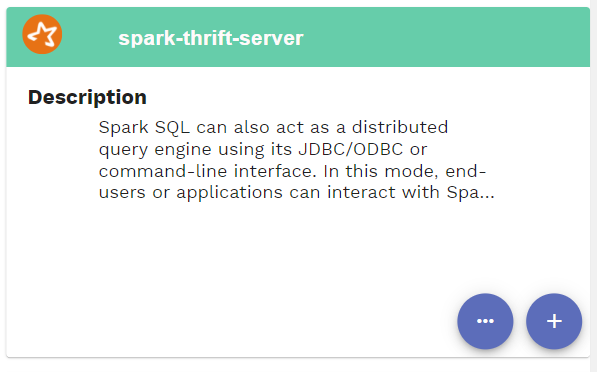

### Pré-requis

Dans cet ordre lancez :
1. lancer le [metastore hive](https://datalab.sspcloud.fr/my-lab/catalogue/inseefrlab-helm-charts-datascience/hive-metastore/deploiement) 
2. lancer le [spark thrift server](https://datalab.sspcloud.fr/my-lab/catalogue/inseefrlab-helm-charts-datascience/spark-thrift-server/deploiement)

notez que le spark thrift server découvre au lancement le metastore hive pour se configurer. Il est donc important de respecter cet ordre

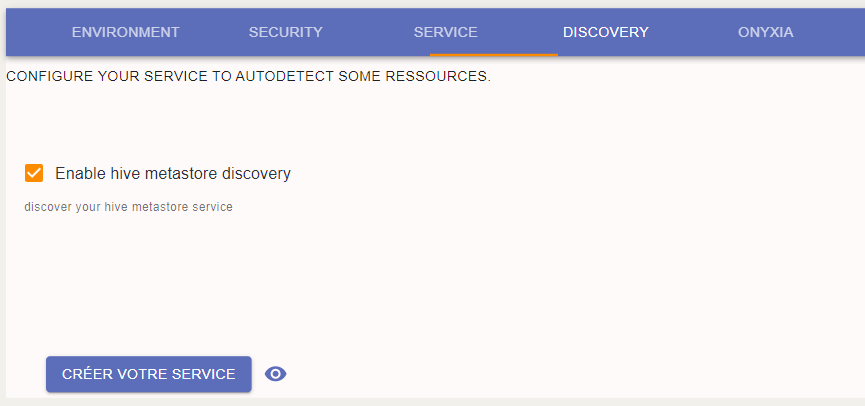

### Vérification



In [5]:
!kubectl get service -l app.kubernetes.io/name=hive-metastore

NAME                        TYPE        CLUSTER-IP      EXTERNAL-IP   PORT(S)    AGE
hive-metastore-1617870268   ClusterIP   10.233.57.242   <none>        9083/TCP   24h


Vous devez avoir un service hive-metastore qui écoute sur le port 9083

In [2]:
!kubectl get service -l app.kubernetes.io/name=spark-thrift-server

NAME                             TYPE        CLUSTER-IP   EXTERNAL-IP   PORT(S)              AGE
spark-thrift-server-1617955509   ClusterIP   None         <none>        10000/TCP,4040/TCP   53m


Vous devez avoir un service spark-thrift-server lancer avec un port 4040 qui correspondant à la spark-ui et qui est directement accessible sur l'ihm d'onyxia

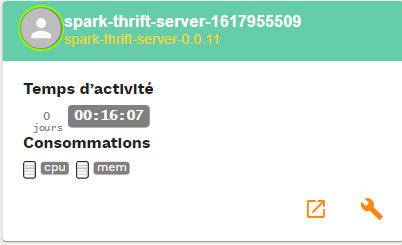

Vous pouvez également vérifier sur cet spark-ui la connexion à Hive en regardant l'onglet environment et dans les propriétés hadoop regarder si vous avez : 

`hive.metastore.uris	thrift://hive-metastore-1617870268:9083`

## Let's go

Si vous avez bien configuré votre environnement on peut commencer.
Pour commencer à regarder mon spark thrift server  qui expose une interface SQL (`spark-thrift-server-1617955509:10000`) nous allons utiliser la librairie pyhive de python



In [2]:
!pip install hivejdbc

     |████████████████████████████████| 457 kB 6.3 MB/s eta 0:00:01


In [3]:
from hivejdbc import connect
# get hive version in order to set the driver
import re
with open('/opt/hive/RELEASE_NOTES.txt') as f:
    file_content = f.read()
version = re.search(r'\bVersion (\d+\.\d+\.\d+)', file_content).group(1)

conn = connect('spark-thrift-server-1618230854', database='default', driver=f'/opt/hive/jdbc/hive-jdbc-{version}-standalone.jar')
with conn.cursor() as cursor:
    cursor.execute('select count(*) from sirene')
    rows = cursor.fetchone()
    print(rows[0])

69911542


Vous pouvez regarder l'ui de spark-thrift-server et observer qu'il y a un onglet supplémentaire JDBC/ODBC server qui vous permet de suivre les sessions clientes.

**Comment interpreter cela?**

Vous avez utilisé un driver JDBC pour vous connecter à un serveur spark thrift qui répond à vos requêtes SQL.
Cela peut être interessant si vous voulez que votre code reste relativement simple sans dépendre de la galaxie spark-hadoop.
Cela peut être également utile si vous voulez que de multiples clients se connecte aux mêmes tables.

Nous allons poursuivre par l'installation d'un outil de visualisation, redash. Il est disponible sur le datalab.
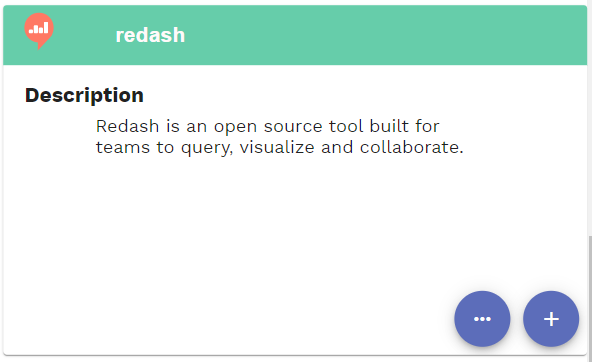

Lors du premier démarrage vous devez configuré un compte d'administration et je vous recommande d'utiliser votre username, email et mot de passe comme sur chaque application en self service avec le mot de passe géré par onyxia (petite clé bleue).

A l'issue de cette première installation, la base de donnée de redash ne sera pas détruite et sera réutilisé à chaque fois que vous la lancerez depuis le catalogue. (De la même façon que le hive-metastore, au travers du pvc comme vu au tutorial précédant).

Ensuite vous pouvez connecter une source de donnée Hive

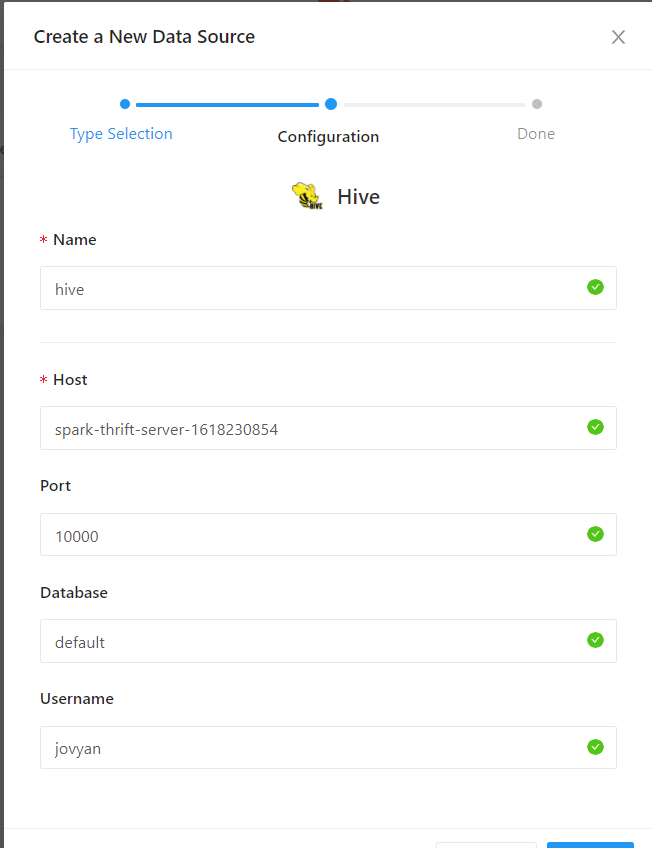

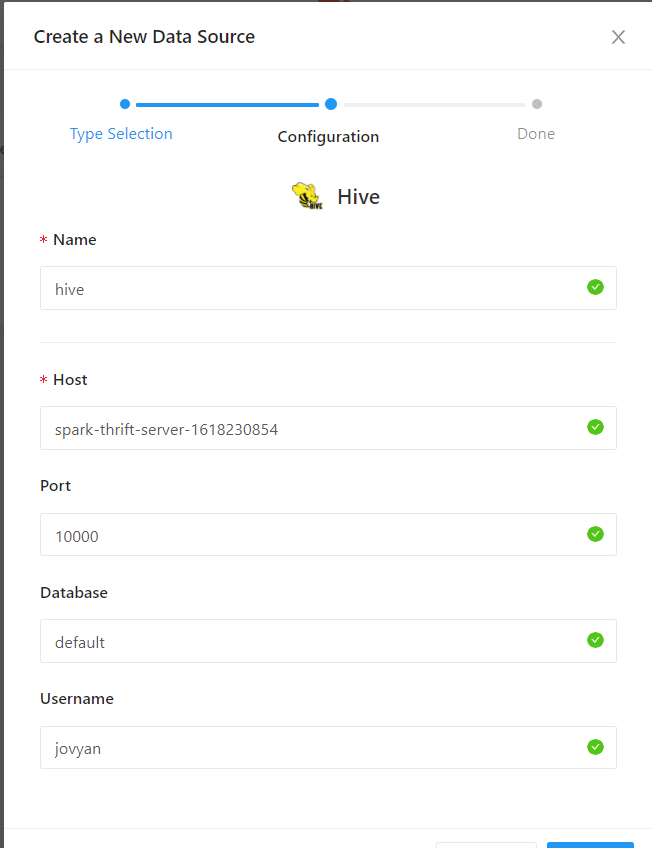

Vous avez dès lors à une petite interface de requête SQL directement connecté à votre driver spark et à vos données sur S3.

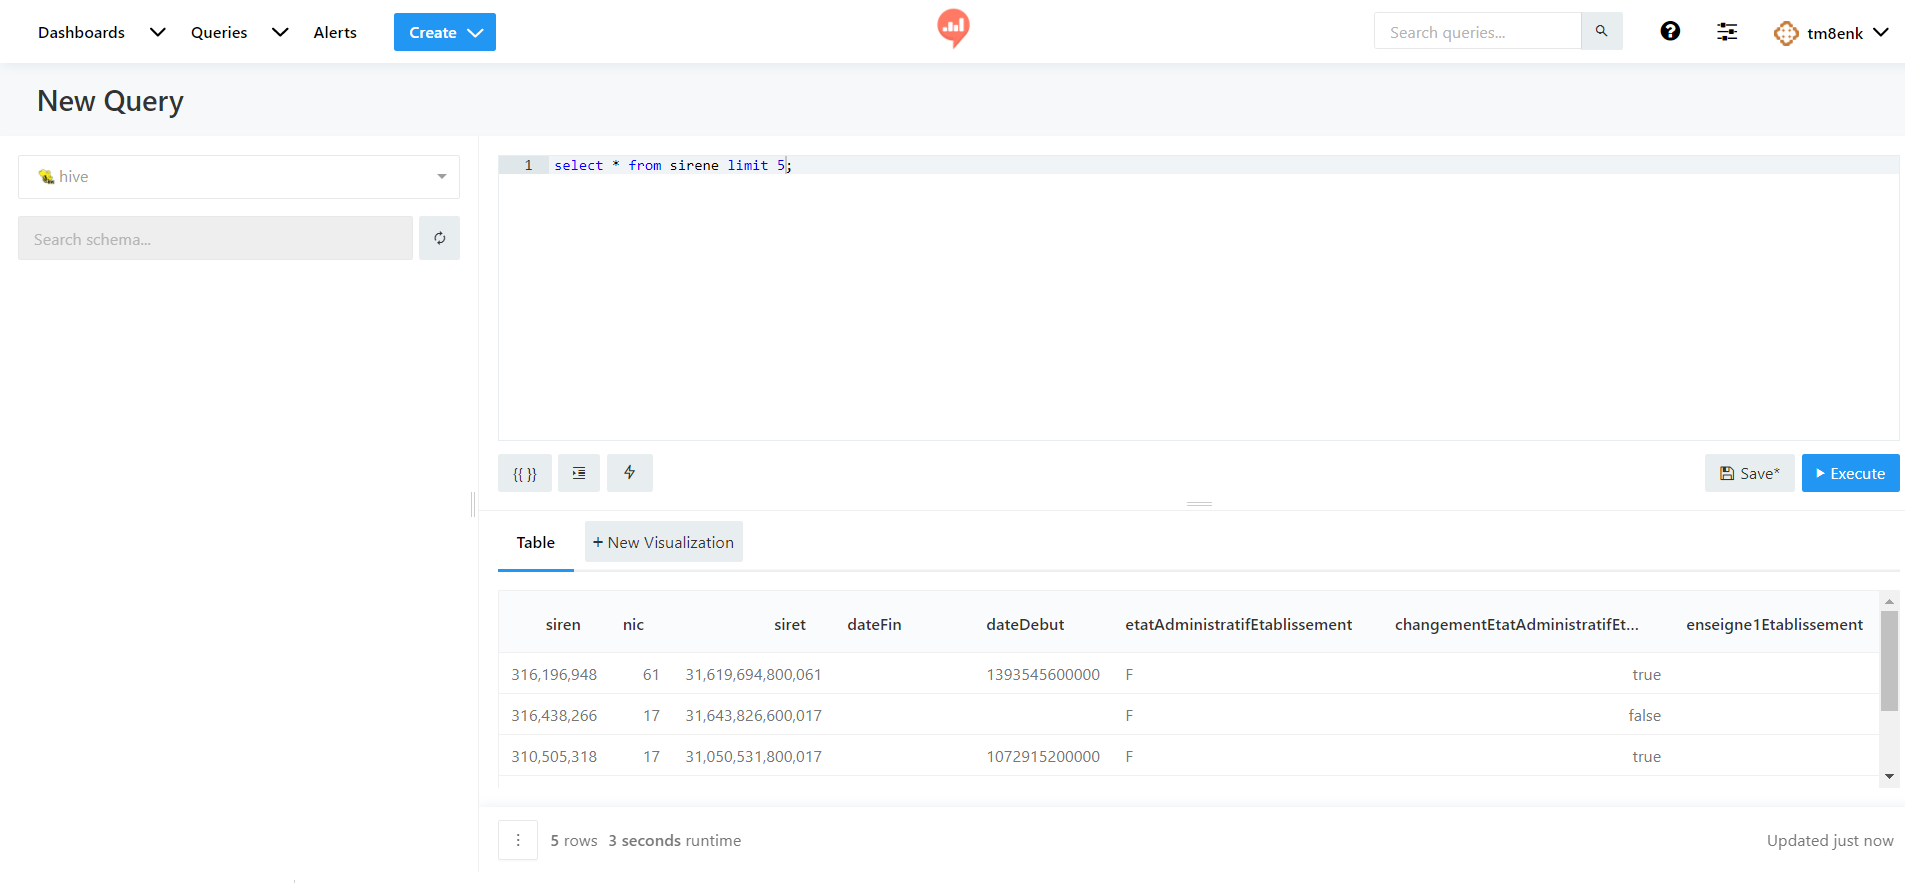

Il est nécessaire d'avoir dans votre métastore hive des tables enregistrés ce qui est le cas si vous avez suivi le tutorial précédant.

Vous pouvez créer des visualisations directement 

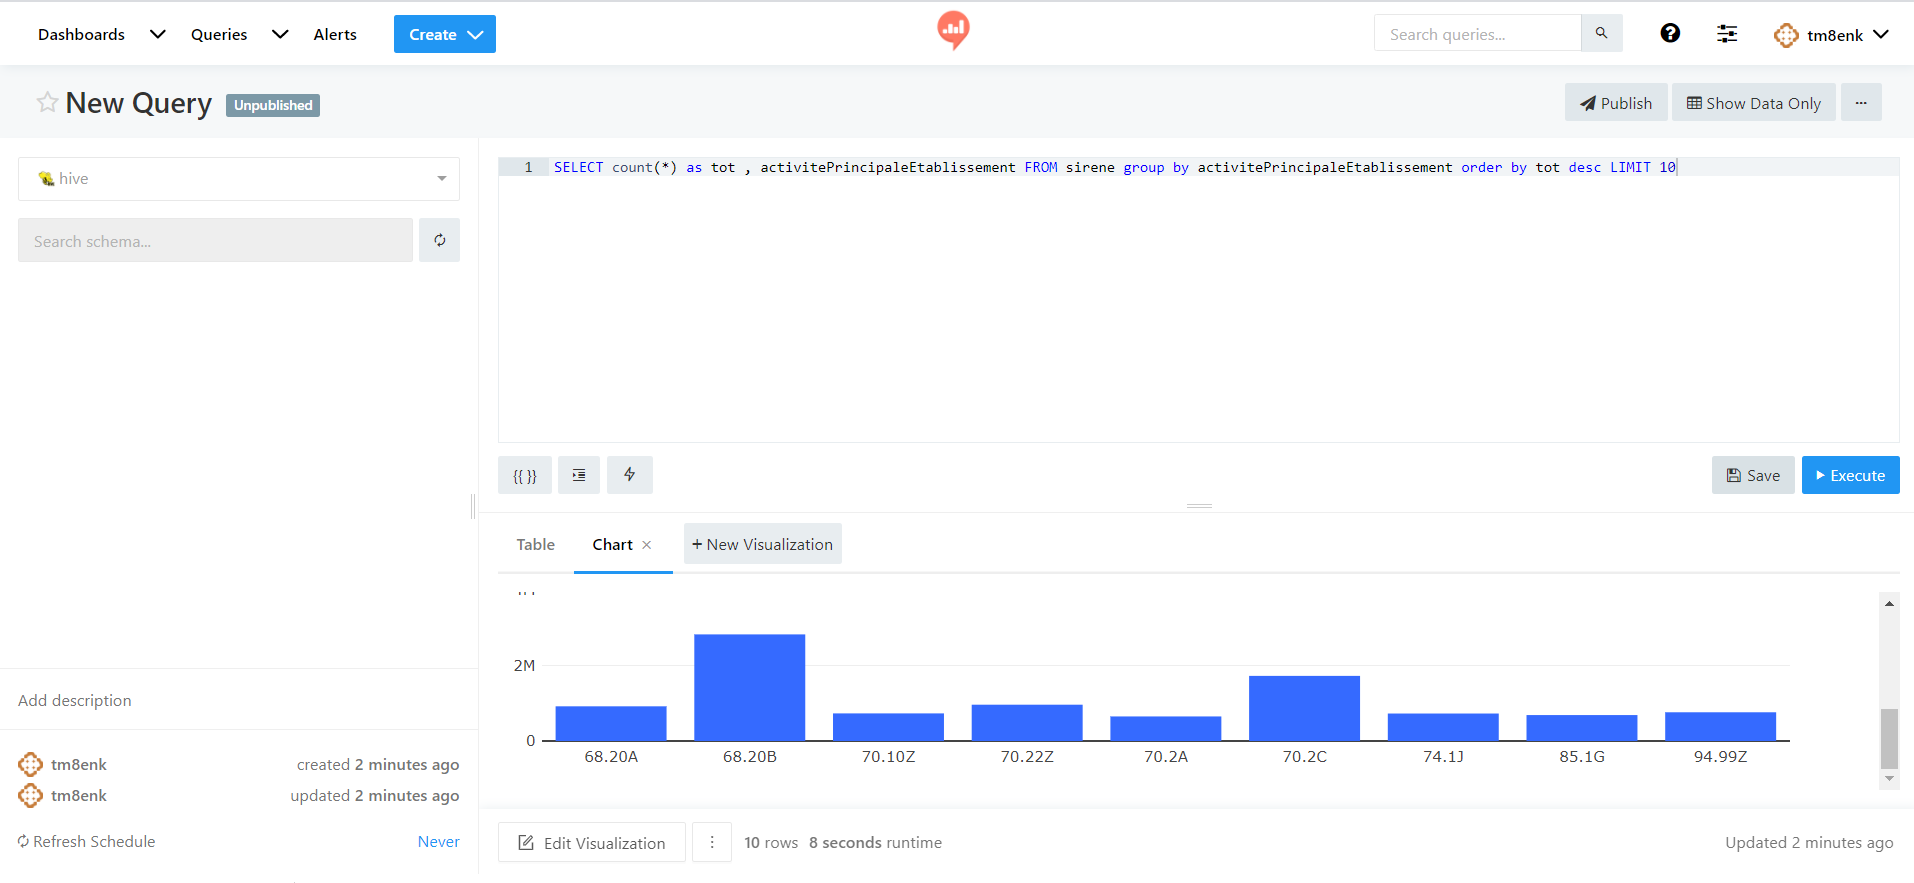

et enfin créer des dashboards à partir de vos requêtes enregistrées et les publier.


**Conclusion :**
    
A partir de tables bien préparées dans S3, d'un metastore hive pour enregistrer les metadonnées des tables et d'un serveur spark thrift, il est très facile de créer des dashboards sur redash à partir de requêtes SQL qui seront distribués sur tout un cluster.

Juste impressionnant